In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap

In [16]:
import numpy as np

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
import warnings

In [7]:
warnings.filterwarnings('ignore')

In [8]:
import seaborn as sns

In [9]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm

In [10]:
from scipy.stats import kde

In [11]:
from tqdm import tqdm_notebook

In [12]:
from scipy.optimize import minimize

## синтезирую задачу

In [17]:
x_class0 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([5, 5])

In [18]:
x_class1 = np.random.randn(1000, 2)*np.array([3, 2])+np.array([5, -5])

In [19]:
x_class2 = np.random.randn(1000, 2)*np.array([2, 3])+np.array([-5, -5])

In [20]:
x_class3 = np.random.randn(1000, 2)*np.array([3, 2])+np.array([-5, 5])

In [21]:
nbins = 300
xmesh, ymesh = np.mgrid[-15:15:nbins*1j, -15:15:nbins*1j]

In [22]:
rv = mnorm([5, 5], [[2.0, 0.0], [0.0, 3.0]])
norm_class0 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [23]:
rv = mnorm([5, -5], [[3.0, 0.0], [0.0, 2.0]])
norm_class1 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [24]:
rv = mnorm([-5, -5], [[2.0, 0.0], [0.0, 3.0]])
norm_class2 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [25]:
rv = mnorm([-5, 5], [[3.0, 0.0], [0.0, 2.0]])
norm_class3 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [26]:
y = np.squeeze(np.concatenate([np.zeros((1000,1), dtype=int),
                               np.ones((1000,1), dtype=int),
                               np.ones((1000,1), dtype=int)*2,
                               np.ones((1000,1), dtype=int)*3],
                              axis=0))

In [27]:
x = np.concatenate([x_class0, x_class1, x_class2, x_class3], axis=0)
x.shape

(4000, 2)

In [28]:
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'gray'}

In [29]:
cmaps = ['Reds', 'Greens', 'Blues', 'Greys']

In [30]:
clabels = [colors[l] for l in y]

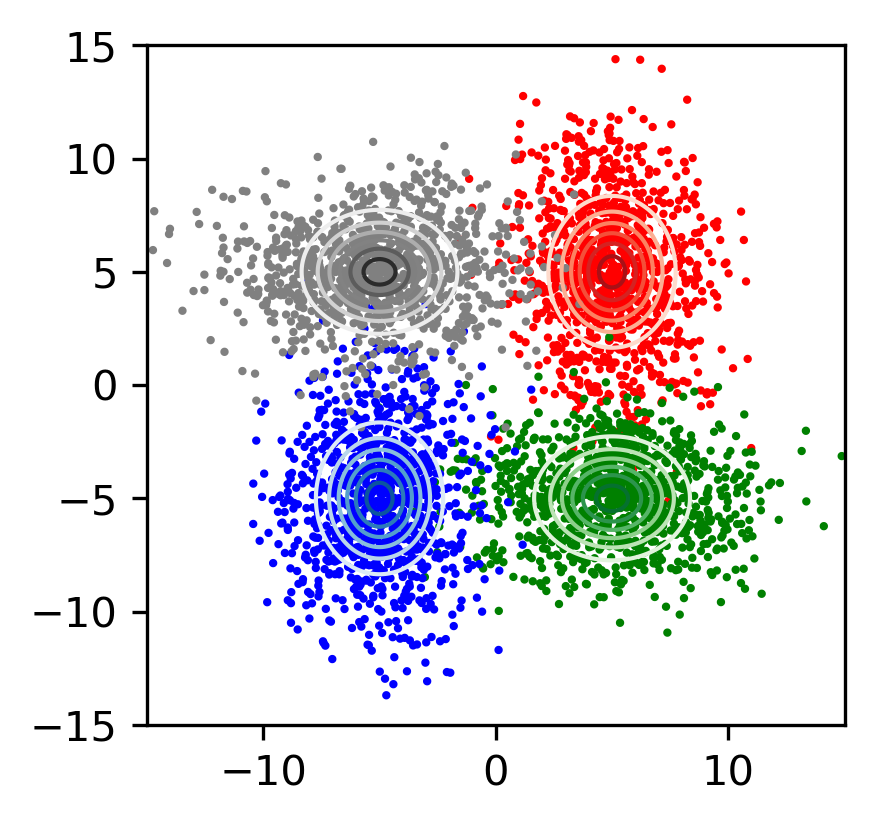

In [31]:
f = plt.figure(figsize=(3,3), dpi=300)
plt.scatter(x[:,0], x[:,1], s=1, c=clabels)
for class_label,norm in zip([0,1,2,3],
                            [norm_class0, norm_class1, norm_class2, norm_class3]):
    _ = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)

In [32]:
def one_hot(arr):
    classes = np.unique(y)
    num_classes = len(classes)
    return classes,np.squeeze(np.eye(num_classes)[arr.reshape(-1)])

In [33]:
classes,y_oh = one_hot(y)

In [36]:
y_oh[-10:]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

## Мультиномиальная логистическая регрессия своими руками

#### implementing loss function and its gradient w.r.t. parameters $\theta$

In [43]:
def softmax(z):
    z_clipped = z-z.max()
    log_softmax = z_clipped - jnp.log(jnp.sum(jnp.exp(z_clipped), axis=-1, keepdims=True))
    softmax_values = jnp.exp(log_softmax)
    return softmax_values

In [44]:
def compute_probabilities(X_matrix, theta):
    z = jnp.dot(X_matrix, theta)
    p = softmax(z)
    return p

In [45]:
def multinomial_cross_entropy(p_pred, y_true):
    return -jnp.sum(jnp.multiply(y_true, jnp.log(p_pred)), axis=-1, keepdims=True)

In [46]:
def multinomial_cross_entropy_loss(X, y, curr_theta):
    theta_matr = jnp.reshape(curr_theta, (x.shape[1]+1, 4))
    X_0 = jnp.ones((X.shape[0], 1), dtype=jnp.float64)
    X_matrix = jnp.concatenate([X_0, X], axis=1)
    p = compute_probabilities(X_matrix, theta_matr)
    l = multinomial_cross_entropy(p, y)
    return jnp.squeeze(jnp.mean(l, axis=0, keepdims=True))

In [48]:
loss_fn = jit(multinomial_cross_entropy_loss)

In [49]:
grad_fn = jit(grad(loss_fn, argnums=2))

In [50]:
theta_start = np.random.randn(x.shape[1]+1, 4).flatten()
theta_start.shape

(12,)

In [51]:
theta_start

array([-0.11241002,  0.12516819,  0.43079329, -0.27124282, -0.46261623,
       -0.10992826, -0.60836372, -1.03481437, -0.67641917,  0.58472335,
        0.95397466,  0.37235403])

In [52]:
curr_loss = loss_fn(x,y_oh,theta_start)
curr_loss

DeviceArray(5.7491245, dtype=float32)

In [53]:
curr_loss_grad = grad_fn(x,y_oh,theta_start)
curr_loss_grad.shape

(12,)

In [54]:
curr_loss_grad

DeviceArray([ 0.16878584, -0.08837935,  0.04402816, -0.12443469,
             -0.99947405, -0.3692337 ,  0.9030889 ,  0.4656187 ,
             -3.5842395 ,  1.7422303 ,  2.9464192 , -1.1044106 ],            dtype=float32)

In [55]:
loss_history = []
optimization_result = minimize(lambda t: float(loss_fn(x, y_oh, t)),
                               theta_start,
                               jac = lambda t: np.array(grad_fn(x, y_oh, t)).flatten(),
                               callback = lambda t: loss_history.append(float(loss_fn(x,y_oh,t))))

In [56]:
optimization_result

      fun: 0.1386510580778122
 hess_inv: array([[ 45.51113232,  21.12997253,   3.44733435, -69.08889026,
         -2.12835396,   3.81503904,   4.46435967,  -6.15370693,
         -7.05688753,   0.61128151,  -1.76644629,   8.21345903],
       [ 21.12997253,  85.25762596, -66.39514908, -38.99307664,
          2.5519583 ,  -3.91436203,  -2.99112934,   4.34974795,
         -5.76025496,  11.75715957,  -9.50557083,   3.51120779],
       [  3.44733435, -66.39514908,  65.15137725,  -1.20322178,
         -4.98322062,   5.06650162,   6.64837828,  -6.72953417,
         -0.9017348 ,  -7.91328936,  10.29266436,  -1.47922153],
       [-69.08889026, -38.99307664,  -1.20322178, 110.28592624,
          4.5596257 ,  -4.96718026,  -8.12163349,   8.53351028,
         13.71896349,  -4.45522626,   0.97941553, -10.24551974],
       [ -2.12835396,   2.5519583 ,  -4.98322062,   4.5596257 ,
          6.11289481,   3.99181219,  -5.45952036,  -3.64511844,
          0.71290767,  -1.42888055,  -0.86397661,   1.57996

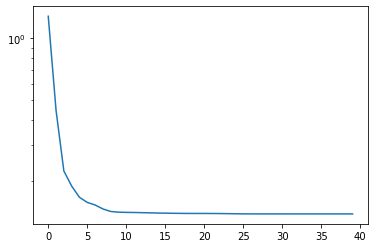

In [57]:
plt.plot(loss_history)
plt.yscale('log')

In [58]:
theta_matr = jnp.reshape(optimization_result.x, (x.shape[1]+1, 4))

In [59]:
theta_matr

array([[-0.15137278,  0.09915406,  0.11771459,  0.10681368],
       [ 0.34057744,  0.07443086, -1.39141227, -1.23931787],
       [ 0.9684048 , -0.50428482, -0.31501216,  1.08552231]])

In [60]:
X_0 = jnp.ones((x.shape[0], 1), dtype=np.float64)
X_matrix = np.concatenate([X_0, x], axis=1)
pred_proba = compute_probabilities(X_matrix, theta_matr)

In [61]:
pred_proba.shape

(4000, 4)

In [62]:
pred_proba[0]

DeviceArray([9.9955380e-01, 3.0577081e-05, 2.9552735e-08, 4.1590122e-04],            dtype=float32)

In [63]:
y[0]

0

In [64]:
y_pred = classes[np.argmax(pred_proba, axis=1)]

In [65]:
np.mean(y_pred == y)

0.952

In [70]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices], X[oob_indices, :], y[oob_indices]
    else:
        return X[sample_indices, :], y[sample_indices]

### Multinomial logistic regression implementation (without any regularizations, with default optimization parameters)

In [71]:
class MultinomialLogRegression:
    def __init__(self):
        self.theta = None
    
    def softmax(self, z):
        z_clipped = z-z.max()
        log_softmax = z_clipped - jnp.log(jnp.sum(jnp.exp(z_clipped), axis=-1, keepdims=True))
        softmax_values = jnp.exp(log_softmax)
        return softmax_values
    
    def compute_probabilities(self, X_matrix, theta):
        z = jnp.dot(X_matrix, theta)
        p = self.softmax(z)
        return p
    
    def multinomial_cross_entropy(self, p_pred, y_true):
        return -jnp.sum(jnp.multiply(y_true, jnp.log(p_pred)), axis=-1, keepdims=True)
    
    def multinomial_cross_entropy_loss(self, X, y, curr_theta):
        theta_matr = jnp.reshape(curr_theta, (X.shape[1]+1, len(self.classes)))
        X_0 = jnp.ones((X.shape[0], 1), dtype=jnp.float64)
        X_matrix = jnp.concatenate([X_0, X], axis=1)
        p = self.compute_probabilities(X_matrix, theta_matr)
        l = self.multinomial_cross_entropy(p, y)
        return jnp.squeeze(jnp.mean(l, axis=0, keepdims=True))
    
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (y.ndim == 1), "y should be 1-dimensional"
        
        self.classes,y_onehot = one_hot(y)
        
        self.loss_fn = jit(self.multinomial_cross_entropy_loss)
        self.grad_fn = jit(grad(self.loss_fn, argnums=2))
        
        theta_start = np.random.randn(X.shape[1]+1, len(self.classes)).flatten()
        loss_history = []
        optimization_result = minimize(lambda t: float(self.loss_fn(X, y_onehot, t)),
                                       theta_start,
                                       jac = lambda t: np.array(self.grad_fn(X, y_onehot, t)).flatten(),
                                       callback = lambda t: loss_history.append(float(self.loss_fn(X, y_onehot, t))))
        
        self.theta = optimization_result.x
        return loss_history
    
    def predict(self, X, return_proba = False):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert (self.theta is not None), "parameters are None. perhaps, you should fit the model first."
        
        X_0 = np.ones((X.shape[0], 1), dtype=np.float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        theta_matr = jnp.reshape(self.theta, (X.shape[1]+1, len(self.classes)))
        pred_proba = self.compute_probabilities(X_matrix, theta_matr)
        y_pred = self.classes[np.argmax(pred_proba, axis=1)]
        
        if return_proba:
            return y_pred, pred_proba
        else:
            return y_pred

In [72]:
B = 2000
sample_size = x.shape[0]
Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
MLR = MultinomialLogRegression()
MLR.fit(Xtrain, ytrain)
yoob_pred,yoob_proba = MLR.predict(Xoob, return_proba=True)
print('accuracy: ' + str(np.mean(np.squeeze(yoob_pred)==yoob)))

accuracy: 0.9494268374915711


In [50]:
B = 1000
sample_size = x.shape[0]
acc = []
for i in tqdm_notebook(range(B), total=B):
    Xtrain,ytrain,Xoob,yoob = sample_bootstrap(x,y, sample_size=sample_size, return_OOB_sample=True)
    MLR = MultinomialLogRegression()
    _ = MLR.fit(Xtrain, ytrain)
    yoob_pred,yoob_proba = MLR.predict(Xoob, return_proba=True)
    acc.append(np.mean(np.squeeze(yoob_pred)==yoob))

In [52]:
np.array(acc).mean()

0.9530788044591215

In [53]:
np.array(acc).std()

0.00435520955537411

## то же самое, но с использованием sklearn

##### Просто чтобы удостовериться, что наш код работает так же, как у остальных $N$ тысяч специалистов, которые не утруждаются реализовать модель логистической регрессии самостоятельно

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
lrmodel = LogisticRegression()

In [56]:
lrmodel.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
yoob_pred_sk = lrmodel.predict(Xoob)
yoob_proba_sk = lrmodel.predict_proba(Xoob)

##### сверим результаты

In [58]:
np.mean(np.squeeze(yoob_pred) == yoob_pred_sk)

0.9667796610169491

## voilà ↑

### Отобразим оценки вероятностей в пространстве признаков

In [73]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(90000, 2)

In [74]:
preds_mesh,probas_mesh = MLR.predict(x_test_mesh, return_proba=True)

In [75]:
preds_mesh = preds_mesh.reshape(xmesh.shape)
probas_mesh = probas_mesh.reshape(list(xmesh.shape) + [4])

In [76]:
xmesh[preds_mesh==0].shape

(22896,)

In [77]:
ymesh[preds_mesh==0].shape

(22896,)

In [78]:
probas_mesh[:,:,0][preds_mesh==0].shape

(22896,)

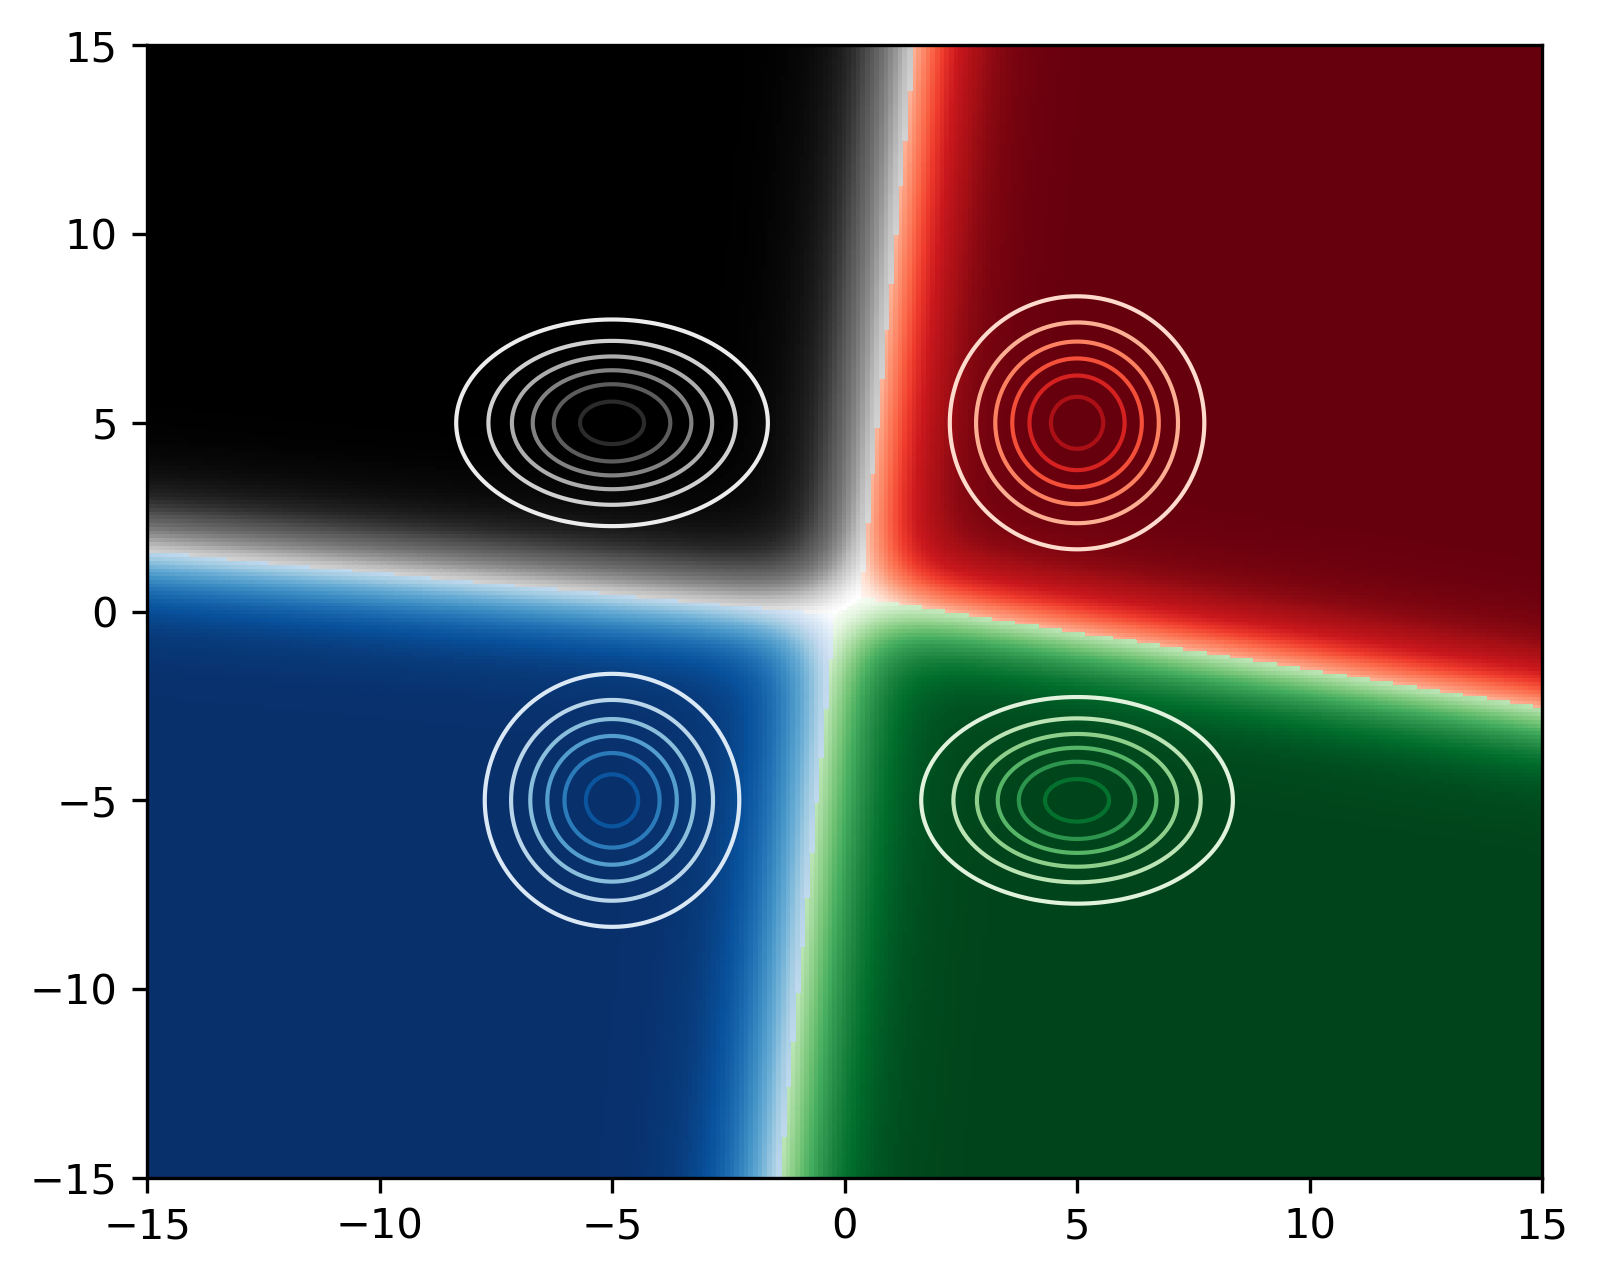

In [79]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (preds_mesh != class_label)
    _ = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
for class_label,norm in zip([0,1,2,3],
                            [norm_class0, norm_class1, norm_class2, norm_class3]):
    _ = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)